In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

from data import *

%load_ext autoreload
%autoreload 2

In [2]:
ds = SimpleSine()
loader = DataLoader(ds, batch_size=16, shuffle=True)

xc, yc = loader.__iter__().__next__()

batch_sz, num_points = xc.size(0), xc.size(1)
context_data = torch.cat((xc, yc), -1).view(batch_sz * num_points, -1)


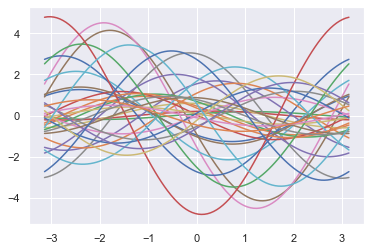

In [3]:
sns.set()
x, _ = ds[0]
for index in range(32):
    _, y = ds[index]
    plt.plot(x, y)

In [59]:
class NP1D(nn.Module):
    def __init__(self, x_dim=1, y_dim=1, h_dim=16, r_dim=32, z_dim=32):
        super(NP1D, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.h_dim = h_dim
        self.g_dim = h_dim
        self.r_dim = r_dim
        self.z_dim = z_dim

        
        self.encoder_block = nn.Sequential(
            nn.Linear(self.x_dim + self.y_dim, self.h_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.h_dim, self.h_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.h_dim, self.r_dim)
        )
        self.decoder_block = nn.Sequential(
            nn.Linear(self.z_dim + self.x_dim, self.g_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.g_dim, self.g_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.g_dim, self.y_dim)
        )
        
        self.mu_layer = nn.Linear(self.r_dim, self.z_dim)
        self.logvar_layer = nn.Linear(self.r_dim, self.z_dim)
        
    def sample(self, batch_sz, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)
        return z
    
    def reparameterize(self, r):
        mu = self.mu_layer(r)
        log_var = self.logvar_layer(r)
        sigma = torch.exp(0.5 * log_var)
        return mu, sigma
    
    def encode(self, x, y):
        batch_sz, num_points = x.size(0), x.size(1)
        xy = torch.cat((x, y), -1).view(batch_sz * num_points, -1)
        r = self.encoder_block(xy).view(batch_sz, num_points, self.r_dim)
        r = torch.mean(r, dim=1).view(batch_sz, -1)
        return r
    
    def decode(self, xt, z):
        xz = torch.cat((xt, z), -1)
        return self.decoder_block(xz)
    
    def forward(self, xc, yc, xt=None, yt=None):
        batch_sz, num_points = xc.size(0), xc.size(1)    
        if self.training:
            
            r_context = self.encode(xc, yc)
            r_target = self.encode(xt, yt)
                    
            # q(z | context)
            mu_c, std_c = self.reparameterize(r_context) # (batch_s x z_dim)
            qz_c = torch.distributions.normal.Normal(mu_c, std_c) 
        
            # q(z | context, target)
            mu_ct, std_ct = self.reparameterize(r_target) # (num_points x z_dim)
            qz_ct = torch.distributions.normal.Normal(mu_ct, std_ct)
            
            z = self.sample(batch_sz, mu_ct, log_var_ct)
            z = z.unsqueeze(1).repeat(1, num_points, 1)

            # prob wrong
            yt_hat = self.decode(xt, z)
            
            return yt_hat, qz_c, qz_ct
            
        else:
            r_context = self.encode(xc, yc)
            
            mu, std = self.reparameterize(r_context)
            q = torch.distributions.normal.Normal(mu, std) 
            z_draw = q.rsample()

            z_draw = z_draw.unsqueeze(1).repeat(1, num_points, 1)
            yt_hat = self.decode(xt, z_draw)
            
            return yt_hat

In [51]:
ds = SimpleSine()
loader = DataLoader(ds, batch_size=16, shuffle=True)

In [60]:
x, y = loader.__iter__().__next__()

xc, yc = x[:8], y[:8]
xt, yt = x[8:], y[8:]

model = NP1D()
model.eval()

yt_hat = model(xc, yc, xt, yt)

In [61]:
x, y = loader.__iter__().__next__()

xc, yc = x[:8], y[:8]
xt, yt = x[8:], y[8:]

model = NP1D()

yt_hat, qz_c, qz_ct = model(xc, yc, xt, yt)

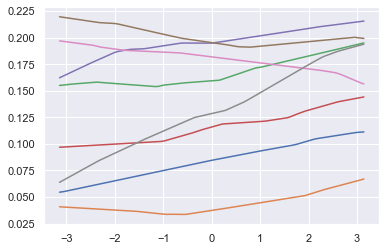

In [62]:
sns.set()
x, _ = ds[0]
for index in range(8):
    y = yt_hat[index].detach().numpy()
    plt.plot(x, y)

In [63]:
ds = SimpleSine()
loader = DataLoader(ds, batch_size=16, shuffle=True)
model = NP1D()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_hist = []

loss_func = torch.nn.MSELoss()
num_epochs = 100


for _ in range(num_epochs):
    epoch_loss = 0
    for it, (x, y) in enumerate(loader):
        model.train()
        batch_sz = x.size(0)
        split = batch_sz // 2

        xc, yc = x[:split], y[:split]
        xt, yt = x[split:], y[split:]

        yt_hat, qz_c, qz_ct = model(xc, yc, xt, yt)

        mse_loss = loss_func(yt_hat, yt)

        kl_loss = torch.distributions.kl_divergence(qz_c, qz_ct).mean(0).sum() 

        loss = mse_loss + kl_loss
        epoch_loss += (loss.item() / batch_sz)

        model.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    
    loss_hist.append(epoch_loss / (it + 1))

    
    
plt.plot(loss_hist)
plt.show()

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.